# Basic Risk Frontier

Future enhancements:
- Consider trends and discounting

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
import sys
from pathlib import Path
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.exposure_base import RevenueExposure
from ergodic_insurance.insurance import InsurancePolicy, InsuranceLayer
from ergodic_insurance.simulation import Simulation, SimulationResults
from ergodic_insurance.ergodic_analyzer import ErgodicAnalyzer
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator
from ergodic_insurance.insurance_program import EnhancedInsuranceLayer, InsuranceProgram

## Define the Corporate Profile

In [ ]:
INITIAL_ASSETS = 10_000_000
ASSET_TURNOVER_RATIO = 1.0  # Revenue = Assets × Turnover
EBITA_MARGIN_TARGET = 0.05  # EBITA after claims and insurance
DEDUCTIBLE = 50_000
LOSS_RATIO = 0.70

NUM_SIMULATIONS = 100
SIM_YEARS = 50

# Create manufacturer configuration
manufacturer_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,
    asset_turnover_ratio=ASSET_TURNOVER_RATIO,  # Revenue = Assets × Turnover
    base_operating_margin=0.10,  # EBITA before claims and insurance (need to calibrate)
    tax_rate=0.25,  # Current US Tax Rate
    retention_ratio=0.70,  # 30% dividends
    ppe_ratio=0.00,  # 0% of assets in PPE, so there is no depreciation expense
)

# Create widget manufacturer
base_manufacturer = WidgetManufacturer(manufacturer_config)

# Create exposure base based on revenue
exposure = RevenueExposure(state_provider=base_manufacturer)


## Define Losses

In [3]:
cur_revenue = base_manufacturer.total_assets * base_manufacturer.asset_turnover_ratio

# Calibrate claim generator for EBITA of 5%
target_ebita_margin = 0.05

generator = ManufacturingLossGenerator(
    attritional_params={
        'base_frequency': 2.85,
        'severity_mean': 40_000,
        'severity_cv': 0.8,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    large_params={
        'base_frequency': 0.20,
        'severity_mean': 500_000,
        'severity_cv': 1.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    catastrophic_params={
        'base_frequency': 0.02,
        'severity_xm': 5_000_000,
        'severity_alpha': 2.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    seed=42
)

In [4]:
deductible = DEDUCTIBLE
policy_limit = 100_000_000


## Estimate Premium Assuming Perfect Distributional Knowledge

In [5]:
pricing_simulation_years = 500_000

total_insured_loss = 0.0
insured_loss_list = []

total_retained_loss = 0.0
retained_loss_list = []

for yr in range(pricing_simulation_years):
    loss_events, loss_meta = generator.generate_losses(duration=1, revenue=base_manufacturer.base_revenue)
    for loss_event in loss_events:
        insured_loss = max(min(loss_event.amount, policy_limit) - deductible,0)
        
        total_insured_loss += insured_loss
        insured_loss_list.append(insured_loss)

        retained_loss = loss_event.amount - insured_loss
        total_retained_loss += retained_loss
        retained_loss_list.append(retained_loss)

average_annual_insured_loss = total_insured_loss / pricing_simulation_years
average_annual_retained_loss = total_retained_loss / pricing_simulation_years
print(f"Average Annual Insured Loss: ${average_annual_insured_loss:,.0f}")
print(f"Average Annual Retained Loss: ${average_annual_retained_loss:,.0f}")

Average Annual Insured Loss: $276,508
Average Annual Retained Loss: $102,530


In [6]:
ground_up_losses = np.asarray(insured_loss_list, dtype=float) + np.asarray(retained_loss_list, dtype=float)
EXCESS_KURTOSIS = pd.Series(ground_up_losses).kurtosis()
print(f"Ground-Up Excess Kurtosis: {EXCESS_KURTOSIS:.2f}")

Ground-Up Excess Kurtosis: 3728.03


Total observations: 1,535,961
Zero (below deductible) count: 1,072,868 (69.8%)
Positive insured losses: 463,093
Mean positive loss: 298,544
Median positive loss: 28,866
95th percentile: 891,644
99th percentile: 6,852,111
Max loss (capped): 99,950,000


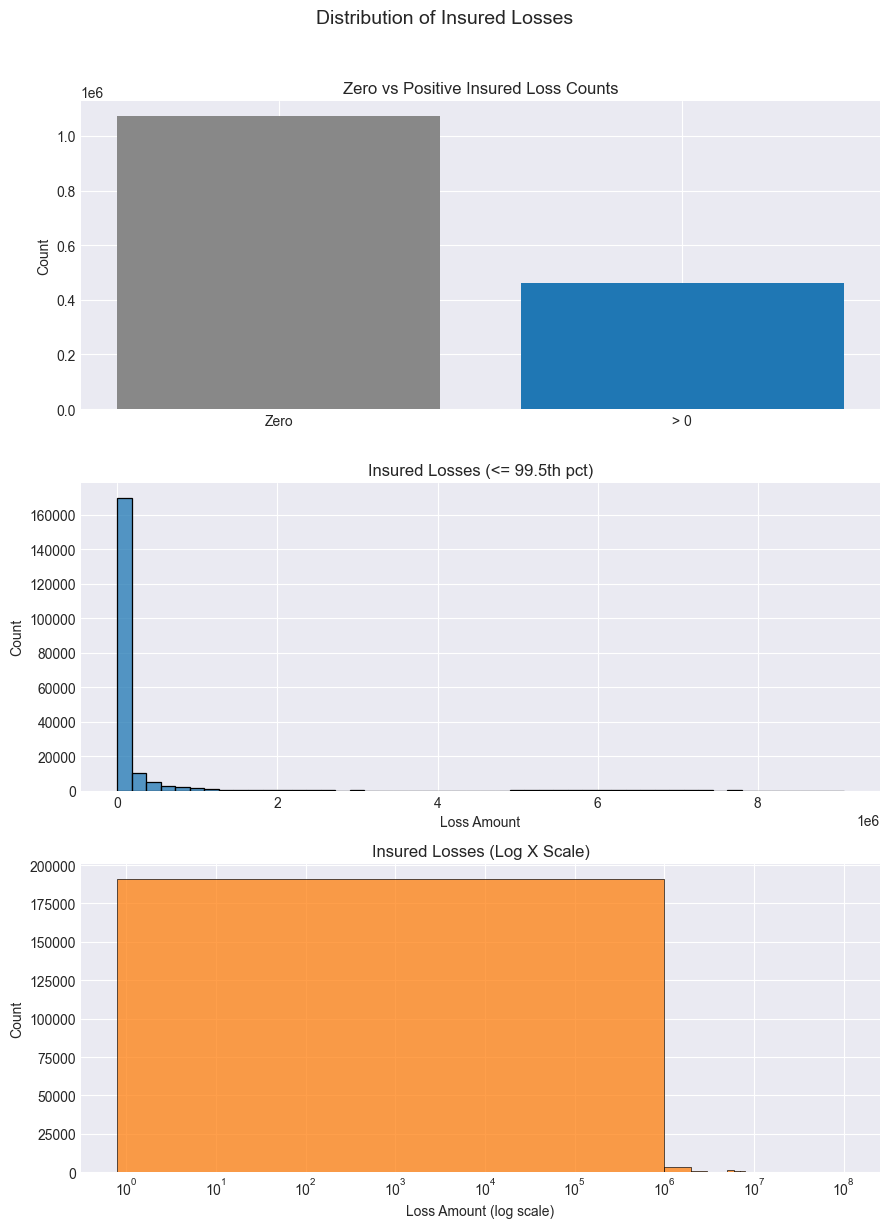

In [7]:
# Plot distribution of insured losses from loss_list

loss_array = np.asarray(insured_loss_list, dtype=float)

# Basic summary
zero_count = np.sum(loss_array == 0)
positive_losses = loss_array[loss_array > 0]
print(f"Total observations: {loss_array.size:,}")
print(f"Zero (below deductible) count: {zero_count:,} ({zero_count / loss_array.size:.1%})")
print(f"Positive insured losses: {positive_losses.size:,}")
if positive_losses.size:
    print(f"Mean positive loss: {positive_losses.mean():,.0f}")
    print(f"Median positive loss: {np.median(positive_losses):,.0f}")
    print(f"95th percentile: {np.percentile(positive_losses,95):,.0f}")
    print(f"99th percentile: {np.percentile(positive_losses,99):,.0f}")
    print(f"Max loss (capped): {positive_losses.max():,.0f}")

# Optional down-sample for plotting heavy tails
max_points = 200_000
if positive_losses.size > max_points:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(positive_losses.size, size=max_points, replace=False)
    plot_positive = positive_losses[sample_idx]
else:
    plot_positive = positive_losses

fig, axes = plt.subplots(3, 1, figsize=(9, 12))

# Zero vs positive
axes[0].bar(['Zero','> 0'], [zero_count, positive_losses.size], color=['#888','#1f77b4'])
axes[0].set_title('Zero vs Positive Insured Loss Counts')
axes[0].set_ylabel('Count')

# Histogram (linear scale, truncated upper tail to 99.5% for visibility)
if positive_losses.size:
    upper_cut = np.percentile(plot_positive, 99.5)
    sns.histplot(plot_positive[plot_positive <= upper_cut],
                 bins=50, ax=axes[1], color='#1f77b4')
    axes[1].set_title('Insured Losses (<= 99.5th pct)')
    axes[1].set_xlabel('Loss Amount')

# Histogram (log x scale for tail)
if positive_losses.size:
    sns.histplot(plot_positive, bins=100, ax=axes[2], color='#ff7f0e')
    axes[2].set_xscale('log')
    axes[2].set_title('Insured Losses (Log X Scale)')
    axes[2].set_xlabel('Loss Amount (log scale)')

fig.suptitle('Distribution of Insured Losses', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [8]:
loss_ratio = LOSS_RATIO

annual_premium = average_annual_insured_loss / loss_ratio
print(f"Annual Premium: ${annual_premium:,.0f}")

total_cost_of_risk = annual_premium + average_annual_retained_loss
print(f"Total Annual Cost of Risk: ${total_cost_of_risk:,.0f}")

Annual Premium: $395,011
Total Annual Cost of Risk: $497,541


In [9]:
cur_operating_income = base_manufacturer.calculate_operating_income(cur_revenue)

cur_net_income = base_manufacturer.calculate_net_income(
                    operating_income=cur_operating_income,
                    collateral_costs=0.0,
                    insurance_premiums=annual_premium,
                    insurance_losses=average_annual_retained_loss,
                    use_accrual=True,
                    time_resolution="annual",
                )

cur_net_income

376844.09802142094

In [10]:
target_net_income = base_manufacturer.base_revenue * target_ebita_margin * (1 - base_manufacturer.tax_rate)
target_net_income


375000.0

In [11]:
net_margin_diff = abs(cur_net_income - target_net_income) / cur_revenue

# assert net_margin_diff < 0.0005, f"Net income not within 0.05% of target ({net_margin_diff:.2%} difference)"

In [12]:
net_margin = cur_net_income / cur_revenue
print(f"Net Margin after insurance: {net_margin:.2%}")
print(f"EBITA Margin after insurance: {net_margin / (1 - base_manufacturer.tax_rate):.2%}")

Net Margin after insurance: 3.77%
EBITA Margin after insurance: 5.02%


## Define the Insurance Program

In [13]:

all_layers = EnhancedInsuranceLayer(
                attachment_point=deductible,
                limit=policy_limit,
                limit_type='per-occurrence',
                base_premium_rate=annual_premium / policy_limit
            )

program = InsuranceProgram([all_layers])

In [14]:
total_premium = program.calculate_annual_premium()
total_premium

np.float64(395010.77364881756)

## Begin the Study
- Run 50 years, repricing each time
  - Adjust premium appropriately to reflect loss costs
- Study results
- Set up additional parameters
- Study aggregate results and frontiers

### Define the Business Financials

In [15]:
# Create manufacturer configuration
manufacturer_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,
    asset_turnover_ratio=ASSET_TURNOVER_RATIO,  # Revenue = Assets × Turnover
    base_operating_margin=0.10,  # EBITA before claims and insurance (need to calibrate)
    tax_rate=0.25,  # Current US Tax Rate
    retention_ratio=0.70,  # 30% dividends
    ppe_ratio=0.00,  # 0% of assets in PPE, so there is no depreciation expense
)

# Create widget manufacturer
base_manufacturer = WidgetManufacturer(manufacturer_config)

# Create exposure base based on revenue
exposure = RevenueExposure(state_provider=base_manufacturer)

cur_revenue = base_manufacturer.total_assets * base_manufacturer.asset_turnover_ratio

# Calibrate claim generator for EBITA of 5%
target_ebita_margin = 0.05

generator = ManufacturingLossGenerator(
    attritional_params={
        'base_frequency': 2.85,
        'severity_mean': 40_000,
        'severity_cv': 0.8,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    large_params={
        'base_frequency': 0.20,
        'severity_mean': 500_000,
        'severity_cv': 1.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    catastrophic_params={
        'base_frequency': 0.02,
        'severity_xm': 5_000_000,
        'severity_alpha': 2.5,
        'revenue_scaling_exponent': 1.0,
        'reference_revenue': cur_revenue
    },
    seed=42
)

deductible = 50_000
policy_limit = 40_000_000

pricing_simulation_years = 500_000

total_insured_loss = 0.0
insured_loss_list = []

total_retained_loss = 0.0
retained_loss_list = []

for yr in range(pricing_simulation_years):
    loss_events, loss_meta = generator.generate_losses(duration=1, revenue=base_manufacturer.base_revenue)
    for loss_event in loss_events:
        insured_loss = max(min(loss_event.amount, policy_limit) - deductible,0)
        
        total_insured_loss += insured_loss
        insured_loss_list.append(insured_loss)

        retained_loss = loss_event.amount - insured_loss
        total_retained_loss += retained_loss
        retained_loss_list.append(retained_loss)

average_annual_insured_loss = total_insured_loss / pricing_simulation_years
average_annual_retained_loss = total_retained_loss / pricing_simulation_years
print(f"Average Annual Insured Loss: ${average_annual_insured_loss:,.0f}")
print(f"Average Annual Retained Loss: ${average_annual_retained_loss:,.0f}")

loss_ratio = 0.70

annual_premium = average_annual_insured_loss / loss_ratio
print(f"Annual Premium: ${annual_premium:,.0f}")

total_cost_of_risk = annual_premium + average_annual_retained_loss
print(f"Total Annual Cost of Risk: ${total_cost_of_risk:,.0f}")

cur_operating_income = base_manufacturer.calculate_operating_income(cur_revenue)

cur_net_income = base_manufacturer.calculate_net_income(
                    operating_income=cur_operating_income,
                    collateral_costs=0.0,
                    insurance_premiums=annual_premium,
                    insurance_losses=average_annual_retained_loss,
                    use_accrual=True,
                    time_resolution="annual",
                )

cur_net_income

target_net_income = base_manufacturer.base_revenue * target_ebita_margin * (1 - base_manufacturer.tax_rate)
target_net_income

net_margin_diff = abs(cur_net_income - target_net_income) / cur_revenue

# assert net_margin_diff < 0.0005, f"Net income not within 0.05% of target ({net_margin_diff:.2%} difference)"

net_margin = cur_net_income / cur_revenue
print(f"Net Margin after insurance: {net_margin:.2%}")
print(f"EBITA Margin after insurance: {net_margin / (1 - base_manufacturer.tax_rate):.2%}")

Average Annual Insured Loss: $274,793
Average Annual Retained Loss: $104,245
Annual Premium: $392,561
Total Annual Cost of Risk: $496,806
Net Margin after insurance: 3.77%
EBITA Margin after insurance: 5.03%


### Define the Insurance Program

In [16]:
from ergodic_insurance.insurance_pricing import InsurancePricer, PricingParameters

policy_pricer = InsurancePricer(loss_generator=generator,
                                loss_ratio=loss_ratio,
                                parameters=PricingParameters(
                                    loss_ratio=loss_ratio,
                                    simulation_years=100_000
                                    )
                                )

all_layers = EnhancedInsuranceLayer(
                attachment_point=deductible,
                limit=policy_limit,
                limit_type='per-occurrence',
                base_premium_rate=annual_premium / policy_limit  # Use small premium
            )

program = InsuranceProgram([all_layers],
                            pricing_enabled=True,
                            pricer=policy_pricer)

total_premium = program.calculate_annual_premium()
print(f"Total Program Premium: ${total_premium:,.2f}")

# The assertion should check against the small premium
assert abs(total_premium - annual_premium) < 1.0, f"Calculated premium ({total_premium:,.0f}) does not match target premium ({annual_premium:,.0f})"

Total Program Premium: $392,560.96


## Set Up the Simulation

In [17]:
from ergodic_insurance.monte_carlo import MonteCarloEngine, SimulationConfig, SimulationResults

def setup_simulation_engine(n_simulations=10_000, n_years=10, parallel=False, insurance_program=None):
    """Set up Monte Carlo simulation engine."""
    # Create simulation config
    config = SimulationConfig(
        n_simulations=n_simulations,
        n_years=n_years,
        n_chains=4,
        parallel=parallel,
        n_workers=None,
        chunk_size=max(1000, n_simulations // 10),
        use_float32=True,
        cache_results=False,
        progress_bar=True,
        ruin_evaluation=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        working_capital_pct=0.0,  # Set working capital to 0% for full asset revenue generation
        seed=42
    )
    
    if insurance_program is None:
        insurance_program = InsuranceProgram(
                                layers=[],  # Empty list to define no coverage
                                deductible=0.0,  # No deductible needed since all losses are retained
                                pricer=None,
                                name="No Insurance"
                            )

    # Create engine
    engine = MonteCarloEngine(
        loss_generator=generator,
        insurance_program=insurance_program,
        manufacturer=base_manufacturer,
        config=config
    )
    
    return engine

# Create engine
print("Setting up Monte Carlo engine with Insurance...")
engine = setup_simulation_engine(n_simulations=NUM_SIMULATIONS, n_years=SIM_YEARS, parallel=False, insurance_program=program)
print(f"Engine configured: {engine.config.n_simulations:,} simulations, {engine.config.n_years} years")
print(f"Parallel processing: {engine.config.parallel}")
print(f"Number of chains: {engine.config.n_chains}")
print(f"Deductible: {engine.insurance_program.deductible}")

Setting up Monte Carlo engine with Insurance...
Engine configured: 1,000 simulations, 10 years
Parallel processing: False
Number of chains: 4
Deductible: 0.0


### Set Up the Simulation Without Insurance

In [18]:
# Create engine without insurance
print("Setting up Monte Carlo engine without Insurance...")
engine_no_ins = setup_simulation_engine(n_simulations=NUM_SIMULATIONS, n_years=SIM_YEARS, parallel=False, insurance_program=None)
print(f"Engine configured: {engine_no_ins.config.n_simulations:,} simulations, {engine_no_ins.config.n_years} years")
print(f"Parallel processing: {engine_no_ins.config.parallel}")
print(f"Number of chains: {engine_no_ins.config.n_chains}")
print(f"Deductible: {engine_no_ins.insurance_program.deductible}")

Setting up Monte Carlo engine without Insurance...
Engine configured: 1,000 simulations, 10 years
Parallel processing: False
Number of chains: 4
Deductible: 0.0


## Run the Simulation

In [19]:
results = engine.run()
results_no_ins = engine_no_ins.run()

Running simulations:   0%|          | 0/1000 [00:00<?, ?it/s]Company became insolvent - negative equity: $-20,884,870.00
Company became insolvent - negative equity: $-36,126,463.99
Running simulations:   2%|▏         | 20/1000 [00:00<00:04, 198.45it/s]Company became insolvent - negative equity: $-441,922.51
Company became insolvent - negative equity: $-612,853.36
Company became insolvent - negative equity: $-1,628,154.17
Running simulations:   6%|▋         | 63/1000 [00:00<00:04, 198.99it/s]Company became insolvent - negative equity: $-849,126.88
Company became insolvent - negative equity: $-7,720,110.54
Company became insolvent - negative equity: $-1,902,719.91
Running simulations:   8%|▊         | 84/1000 [00:00<00:04, 188.46it/s]Company became insolvent - negative equity: $-13,059,490.18
Company became insolvent - negative equity: $-1,526,435.31
Company became insolvent - negative equity: $-2,548,611.17
Company became insolvent - negative equity: $-316,902.49
Running simulations:  1

In [20]:
import pickle

filename = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt ({EXCESS_KURTOSIS:.0f}) -\
 Ded ({DEDUCTIBLE/1_000:.0f}K) -\
 LR ({LOSS_RATIO}) -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs.pkl"

with open(filename, "wb") as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
filename_no_ins = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt ({EXCESS_KURTOSIS:.0f}) -\
 NOINS -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs.pkl"

with open(filename_no_ins, "wb") as f:
    pickle.dump(results_no_ins, f, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
print(results.summary())

Simulation Results Summary
Simulations: 1,000
Years: 10
Execution Time: 5.46s
Ruin Probability:
  Year 5: 0.10%
  Year 10: 0.20%
Mean Final Assets: $11,412,095
Mean Growth Rate: 0.0139
VaR(99%): $24,496,768
TVaR(99%): $36,316,444
Convergence R-hat: 1.002

Performance Summary
Total Time: 5.46s
Setup: 0.00s
Computation: 5.46s
Serialization: 0.00s (0.0% overhead)
Reduction: 0.00s
Peak Memory: 0.3 MB
CPU Utilization: 0.0%
Throughput: 183 items/s
Speedup: 1.00x

Advanced Aggregation Results:
  p1: $11,422,627
  p5: $11,422,627
  p10: $11,422,627
  p25: $11,445,913
  p50: $11,484,505
  p75: $11,522,719
  p90: $11,568,575
  p95: $11,603,366
  p99: $11,658,327



In [23]:
print(results_no_ins.summary())

Simulation Results Summary
Simulations: 1,000
Years: 10
Execution Time: 5.92s
Ruin Probability:
  Year 5: 5.50%
  Year 10: 11.10%
Mean Final Assets: $7,692,022
Mean Growth Rate: -0.0185
VaR(99%): $16,614,079
TVaR(99%): $28,758,938
Convergence R-hat: 1.002

Performance Summary
Total Time: 5.92s
Setup: 0.00s
Computation: 5.92s
Serialization: 0.00s (0.0% overhead)
Reduction: 0.00s
Peak Memory: 0.3 MB
CPU Utilization: 0.0%
Throughput: 169 items/s
Speedup: 1.00x

Advanced Aggregation Results:
  p1: $-17,297,401
  p5: $-2,903,773
  p10: $-355,176
  p25: $7,294,196
  p50: $10,310,082
  p75: $11,353,258
  p90: $11,893,906
  p95: $12,074,985
  p99: $12,369,164



In [24]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings
import sys
from pathlib import Path
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.exposure_base import RevenueExposure
from ergodic_insurance.insurance import InsurancePolicy, InsuranceLayer
from ergodic_insurance.simulation import Simulation, SimulationResults
from ergodic_insurance.ergodic_analyzer import ErgodicAnalyzer
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator
from ergodic_insurance.insurance_program import EnhancedInsuranceLayer, InsuranceProgram

# Read the specified pickle file (tries results/ directory first)
results_filename = "Cap (10M) - ATR (1.0) - EBITA (0.05) - XS_Kurt (3728) - Ded (50K) - LR (0.7).pkl"

candidate_paths = [Path("results") / results_filename, Path(results_filename)]

if results is None:
    for p in candidate_paths:
        if p.exists():
            with open(p, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded pickle from: {p}")
            break

    if results is None:
        print(f"File not found in: {[str(p) for p in candidate_paths]}")
    else:
        # If this is a SimulationResults object, show a brief summary
        if hasattr(results, "summary"):
            try:
                print(results.summary())
            except Exception as e:
                print(f"Could not print summary: {e}")
        else:
            print(f"Loaded object type: {type(results)}")
else:
    print("Results with insurance already loaded.")

# Read the specified pickle file (tries results/ directory first)
results_no_ins_filename = "Cap (10M) - ATR (1.0) - EBITA (0.05) - XS_Kurt (3728) - NOINS.pkl"

candidate_paths = [Path("results") / results_no_ins_filename, Path(results_no_ins_filename)]

if results_no_ins is None:
    for p in candidate_paths:
        if p.exists():
            with open(p, "rb") as f:
                results_no_ins = pickle.load(f)
            print(f"Loaded pickle from: {p}")
            break

    if results_no_ins is None:
        print(f"File not found in: {[str(p) for p in candidate_paths]}")
    else:
        # If this is a SimulationResults object, show a brief summary
        if hasattr(results_no_ins, "summary"):
            try:
                print(results_no_ins.summary())
            except Exception as e:
                print(f"Could not print summary: {e}")
        else:
            print(f"Loaded object type: {type(results_no_ins)}")
else:
    print("Results without insurance already loaded.")

Results with insurance already loaded.
Results without insurance already loaded.


In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ergodic_insurance.visualization.core import WSJ_COLORS
import numpy as np

# Print results
print(f"\nRuin Probabilities by Time Horizon:")
for yr, prob in results.ruin_probability.items():
    print(f"  {yr} years: {prob*100:.2f}%")

print(f"\nConvergence achieved: {'Yes' if results.convergence else 'No'}")

# --------------------------------------
# Time-Average Growth Rate Histogram (1,1)
# --------------------------------------
fig = go.Figure()

# Growth rates with insurance
growth_rates = np.asarray(results.growth_rates, dtype=float)
growth_rates = growth_rates[np.isfinite(growth_rates)]

# Growth rates without insurance
growth_rates_no_ins = np.asarray(results_no_ins.growth_rates, dtype=float)
growth_rates_no_ins = growth_rates_no_ins[np.isfinite(growth_rates_no_ins)]

growth_pct = growth_rates * 100.0
mean_growth = np.nanmean(growth_pct)
median_growth = np.nanmedian(growth_pct)
p5, p25, p95 = np.nanpercentile(growth_pct, [5, 25, 95])
print(f"Growth Rate Summary With Insurance (%): Mean={mean_growth:.2f}, Median={median_growth:.2f}, 25th={p25:.2f}, 5th={p5:.2f}")

growth_pct_no_ins = growth_rates_no_ins * 100.0
mean_growth_no_ins = np.nanmean(growth_pct_no_ins)
median_growth_no_ins = np.nanmedian(growth_pct_no_ins)
p5_no_ins, p25_no_ins, p95_no_ins = np.nanpercentile(growth_pct_no_ins, [5, 25, 95])
print(f"Growth Rate Summary Without Insurance (%): Mean={mean_growth_no_ins:.2f}, Median={median_growth_no_ins:.2f}, 25th={p25_no_ins:.2f}, 5th={p5_no_ins:.2f}")

# Plot Growth Rate With Insurance
# Kernel Density Estimate (Gaussian) instead of histogram
xs = np.linspace(growth_pct.min(), growth_pct.max(), 400)
n = growth_pct.size
std = np.std(growth_pct, ddof=1)
if std == 0 or n < 2:
    # Fallback: flat line at 0
    density = np.zeros_like(xs)
else:
    bw = 1.06 * std * n ** (-1/5)  # Silverman's rule
    inv_norm = 1.0 / (bw * np.sqrt(2 * np.pi))
    diffs = (xs[:, None] - growth_pct[None, :]) / bw
    density = inv_norm * np.exp(-0.5 * diffs**2).mean(axis=1)

fig.add_trace(
    go.Scatter(
        x=xs,
        y=density,
        mode='lines',
        name='Insurance',
        line=dict(color=WSJ_COLORS.get('blue', '#1f77b4'), width=2)
    )
)

# Plot Growth Rate Without Insurance
# Kernel Density Estimate (Gaussian) instead of histogram
xs_no_ins = np.linspace(growth_pct_no_ins.min(), growth_pct_no_ins.max(), 400)
n_no_ins = growth_pct_no_ins.size
std_no_ins = np.std(growth_pct_no_ins, ddof=1)
if std_no_ins == 0 or n_no_ins < 2:
    # Fallback: flat line at 0
    density = np.zeros_like(xs_no_ins)
else:
    bw = 1.06 * std_no_ins * n_no_ins ** (-1/5)  # Silverman's rule
    inv_norm_no_ins = 1.0 / (bw * np.sqrt(2 * np.pi))
    diffs_no_ins = (xs_no_ins[:, None] - growth_pct_no_ins[None, :]) / bw
    density_no_ins = inv_norm_no_ins * np.exp(-0.5 * diffs_no_ins**2).mean(axis=1)

# Set x-axis to central 99.5% of both distributions (trim 0.25% each tail)
try:
    lower_q, upper_q = .5, 99.5
    lo_ins, hi_ins = np.nanpercentile(growth_pct, [lower_q, upper_q])
    lo_no_ins, hi_no_ins = np.nanpercentile(growth_pct_no_ins, [lower_q, upper_q])
    x_min = min(lo_ins, lo_no_ins)
    x_max = max(hi_ins, hi_no_ins)
    pad = 0.01 * (x_max - x_min) if x_max > x_min else 0.0
    fig.update_xaxes(range=[x_min - pad, x_max + pad])
except Exception as e:
    print(f"Could not apply 99.5% central x-range: {e}")

# Adjust y-axis label to reflect density
fig.update_yaxes(title_text="Density")

# Recompute KDEs on clipped range [-10, 5] and update plot
lower, upper = -5.0, 5.0
# Clear existing traces, shapes, annotations
fig.data = ()
fig.layout.shapes = ()
fig.layout.annotations = ()

# Clip datasets
ins_clip = growth_pct[(growth_pct >= lower) & (growth_pct <= upper)]
no_ins_clip = growth_pct_no_ins[(growth_pct_no_ins >= lower) & (growth_pct_no_ins <= upper)]

xs_clip = np.linspace(lower, upper, 400)

def kde(arr, xs):
    n = arr.size
    if n < 2:
        return np.zeros_like(xs)
    std_ = np.std(arr, ddof=1)
    if std_ == 0:
        return np.zeros_like(xs)
    bw = 1.06 * std_ * n ** (-1/5)
    inv = 1.0 / (bw * np.sqrt(2 * np.pi))
    diffs = (xs[:, None] - arr[None, :]) / bw
    return inv * np.exp(-0.5 * diffs**2).mean(axis=1)

dens_ins = kde(ins_clip, xs_clip) if ins_clip.size else np.zeros_like(xs_clip)
dens_no  = kde(no_ins_clip, xs_clip) if no_ins_clip.size else np.zeros_like(xs_clip)

# Add traces
fig.add_trace(go.Scatter(
    x=xs_clip, y=dens_ins, mode='lines', name='Insurance (clipped)',
    line=dict(color=WSJ_COLORS.get('blue', '#1f77b4'), width=2)
))
fig.add_trace(go.Scatter(
    x=xs_clip, y=dens_no, mode='lines', name='No Insurance (clipped)',
    line=dict(color=WSJ_COLORS.get('orange', '#ff7f0e'), width=2)
))

# Stats on clipped data
if ins_clip.size:
    mean_ins = np.nanmean(ins_clip)
    p25_ins = np.nanpercentile(ins_clip, 25)
    # Add vertical lines for mean and median
    fig.add_vline(x=mean_ins, 
                line_dash='dash', 
                line_color=WSJ_COLORS.get('blue', '#1f77b4'), 
                annotation_text='Mean (Ins)', 
                annotation_position='top right')
    fig.add_vline(x=p25_ins, 
                line_dash='dot', 
                line_color=WSJ_COLORS.get('red', '#d62728'), 
                annotation_text='25th pct (Ins)', 
                annotation_position='top left')
if no_ins_clip.size:
    mean_no = np.nanmean(no_ins_clip)
    p25_no = np.nanpercentile(no_ins_clip, 25)
    # Add vertical lines for mean and median
    fig.add_vline(x=mean_no, 
                line_dash='dash', 
                line_color=WSJ_COLORS.get('orange', '#ff7f0e'), 
                annotation_text='Mean (No Ins)', 
                annotation_position='bottom right')
    fig.add_vline(x=p25_no, 
                line_dash='dot', 
                line_color=WSJ_COLORS.get('red', '#d62728'),
                annotation_text='25th pct (No Ins)', 
                annotation_position='bottom left')


# Update layout
fig.update_layout(
    title={
        "text": "Time-Average Growth Rate Histogram",
        "x": 0.5,
        "xanchor": "center"
    },
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.2,
        yanchor='top'
    ),
    width=800,
    height=500
)

# Axes titles
fig.update_xaxes(title_text="Time-Average Growth Rate (%)",
                range=[lower, upper])

fig.show()


Ruin Probabilities by Time Horizon:
  5 years: 0.10%
  10 years: 0.20%

Convergence achieved: Yes
Growth Rate Summary With Insurance (%): Mean=1.39, Median=1.38, 25th=1.35, 5th=1.33
Growth Rate Summary Without Insurance (%): Mean=-1.85, Median=0.31, 25th=-0.72, 5th=-19.31


In [26]:
import plotly.io as pio

fig_filename = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt (high) -\
 Ded ({DEDUCTIBLE/1_000:.0f}K) -\
 LR ({LOSS_RATIO}) -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs - Growth Rate.png"

pio.write_image(fig, fig_filename, scale=2) # Adjust scale as needed

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ergodic_insurance.visualization.core import WSJ_COLORS
import numpy as np

# Print results
print(f"\nRuin Probabilities by Time Horizon:")
for yr, prob in results.ruin_probability.items():
    print(f"  {yr} years: {prob*100:.2f}%")

print(f"\nConvergence achieved: {'Yes' if results.convergence else 'No'}")

# --------------------------------------
# Ruin probability comparison (1,2)
# --------------------------------------
# Single figure without subplots
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(results.ruin_probability.keys()),
        y=[prob * 100 for prob in results.ruin_probability.values()],
        mode='lines+markers',
        name='Insurance',
        line=dict(width=2, color=WSJ_COLORS.get('blue', '#1f77b4')),
        marker=dict(size=8)
    )
)
fig.add_trace(
    go.Scatter(
        x=list(results_no_ins.ruin_probability.keys()),
        y=[prob * 100 for prob in results_no_ins.ruin_probability.values()],
        mode='lines+markers',
        name='No Insurance',
        line=dict(width=2, color=WSJ_COLORS.get('orange', '#ff7f0e')),
        marker=dict(size=8)
    )
)

# Update layout
fig.update_layout(
    title={
        "text": "Ruin Probability by Time Horizon",
        "x": 0.5,
        "xanchor": "center"
    },
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation='h',
        x=0.5,
        xanchor='center',
        y=-0.2,
        yanchor='top'
    ),
    width=800,
    height=500
)

# Axes titles
fig.update_xaxes(title_text="Time Horizon (years)")
fig.update_yaxes(title_text="Ruin Probability (%)")

fig.show()


Ruin Probabilities by Time Horizon:
  5 years: 0.10%
  10 years: 0.20%

Convergence achieved: Yes


In [28]:
fig_filename = f"results\Cap ({INITIAL_ASSETS/1_000_000:.0f}M) -\
 ATR ({ASSET_TURNOVER_RATIO}) -\
 EBITA ({EBITA_MARGIN_TARGET}) -\
 XS_Kurt (high) -\
 Ded ({DEDUCTIBLE/1_000:.0f}K) -\
 LR ({LOSS_RATIO}) -\
 {NUM_SIMULATIONS/1_000:.0f}K Sims -\
 {SIM_YEARS} Yrs - RoR.png"

pio.write_image(fig, fig_filename, scale=2) # Adjust scale as needed

In [29]:
print(f'Final net asset value with insurance: ${results.final_assets.mean():,.0f} ± ${results.final_assets.std():,.0f}')
print(f'Final net asset value without insurance: ${results_no_ins.final_assets.mean():,.0f} ± ${results_no_ins.final_assets.std():,.0f}')

Final net asset value with insurance: $11,412,095 ± $1,813,715
Final net asset value without insurance: $7,692,022 ± $7,128,893
